In [4]:
import pandas as pd
from src.utility import get_root
import os

file_path = os.path.join(get_root(), "adam_variants_metrics.xlsx")
df = pd.read_excel(file_path)
df.head()

,Dataset,Model,Optimizer,Epoch,Time(s),VRAM(MB),RAM(MB),Train_Loss,Train_Acc,Train_F1,Val_Loss,Val_Acc,Val_F1
0,CIFAR10,ResNet18,Adam,1,45.730279,1830,5170.550781,1.461876,0.476125,0.473262,1.281768,0.5356,0.529542
1,CIFAR10,ResNet18,Adam,2,43.597776,1830,5172.195312,1.051440,0.626100,0.624620,1.098566,0.6173,0.614736
2,CIFAR10,ResNet18,Adam,3,47.103150,1830,5172.621094,0.863780,0.694675,0.694101,1.029244,0.6383,0.640555
3,CIFAR10,ResNet18,Adam,4,41.593714,1830,5172.761719,0.715669,0.746425,0.745754,1.145295,0.6176,0.627760
4,CIFAR10,ResNet18,Adam,5,42.749735,1830,5172.789062,0.587369,0.791300,0.791066,1.079515,0.6541,0.653204


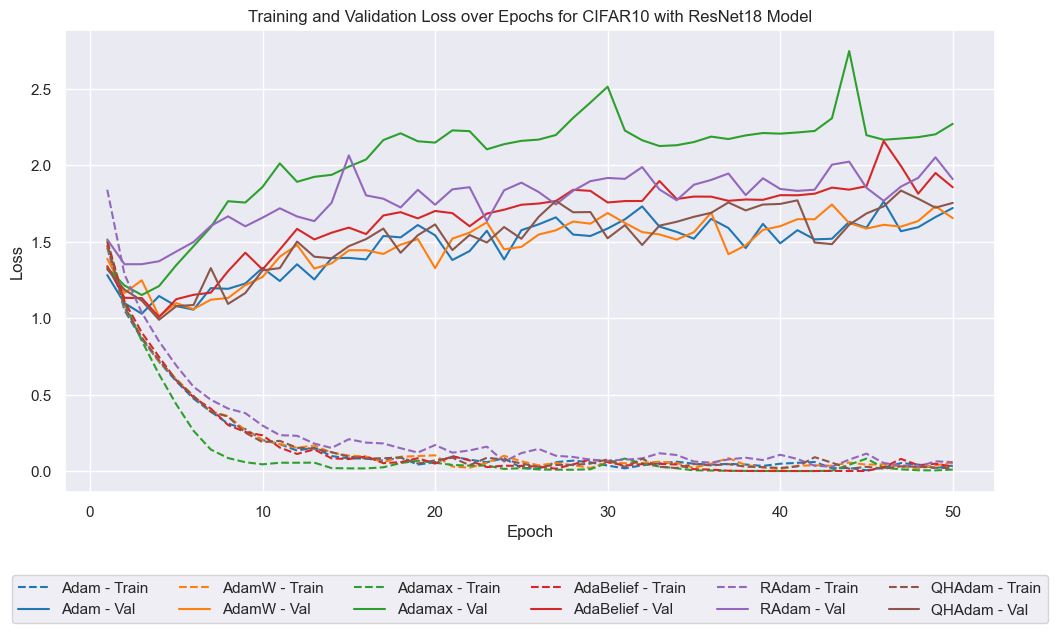

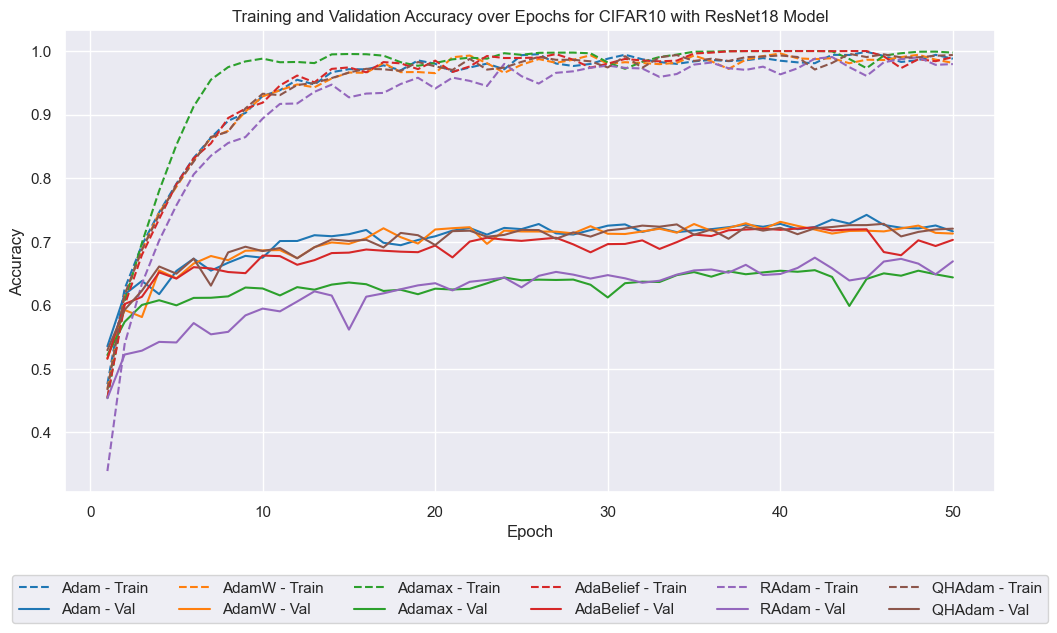

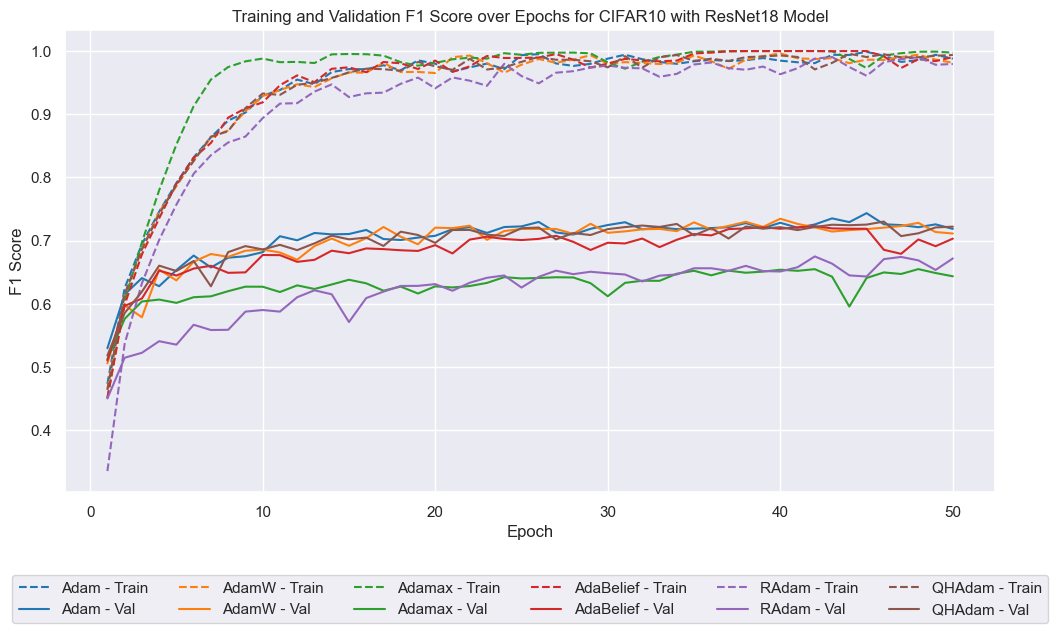

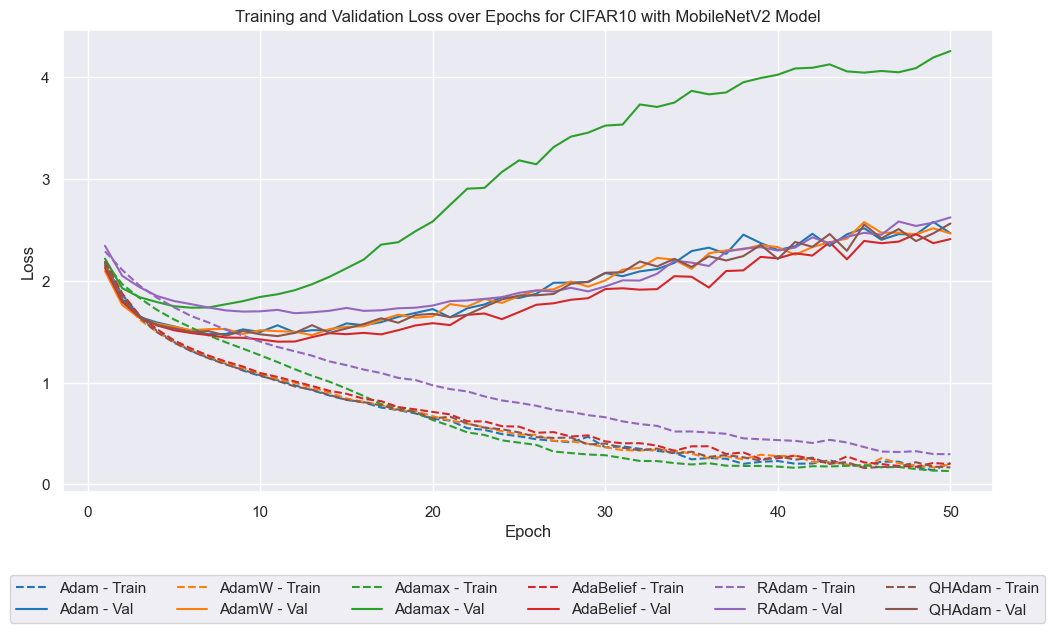

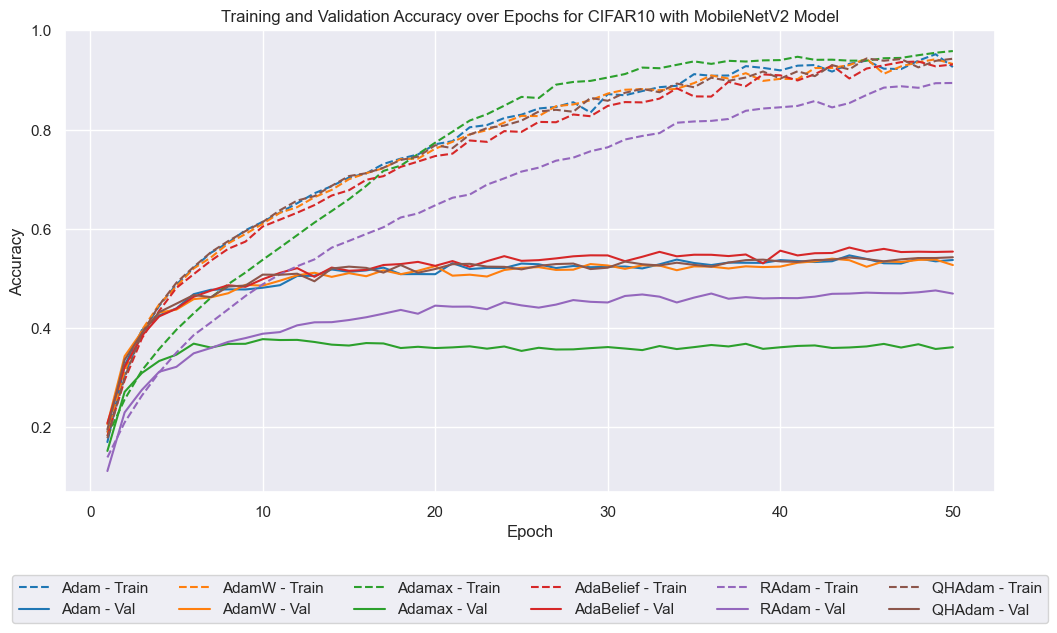

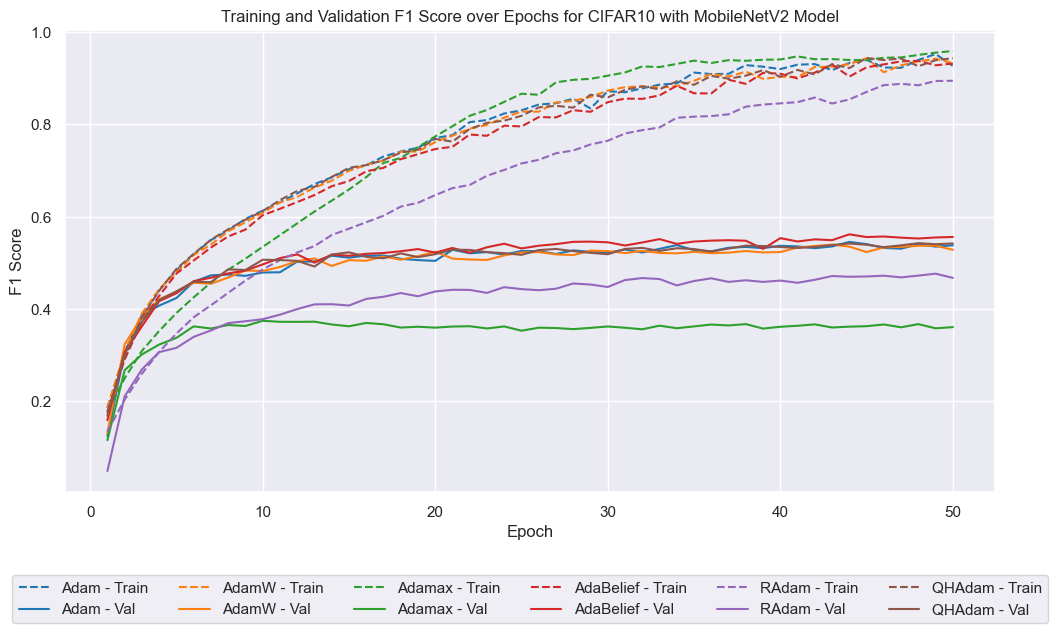

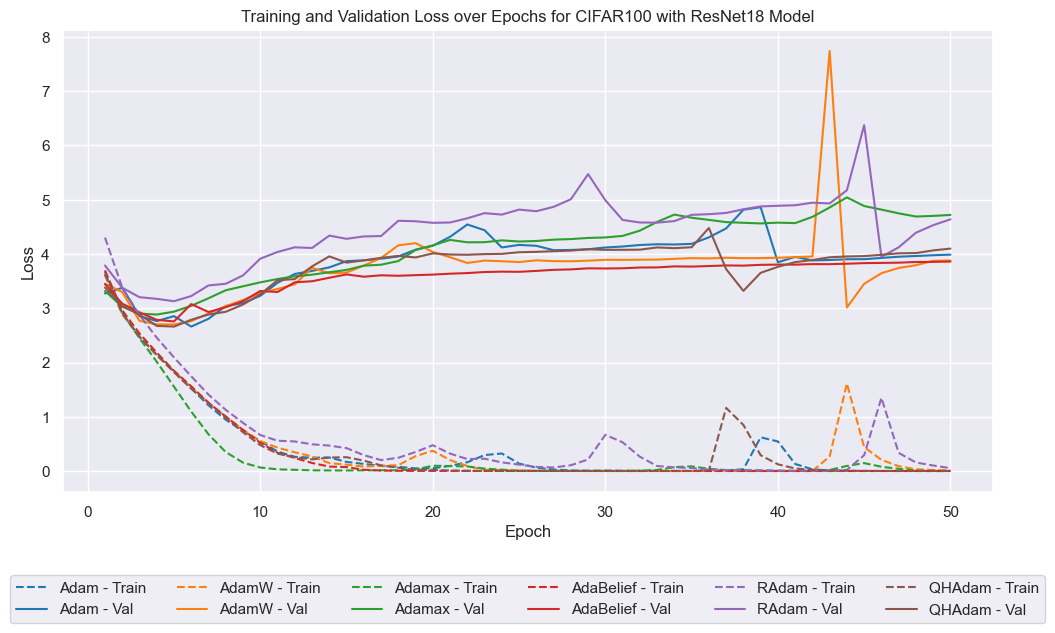

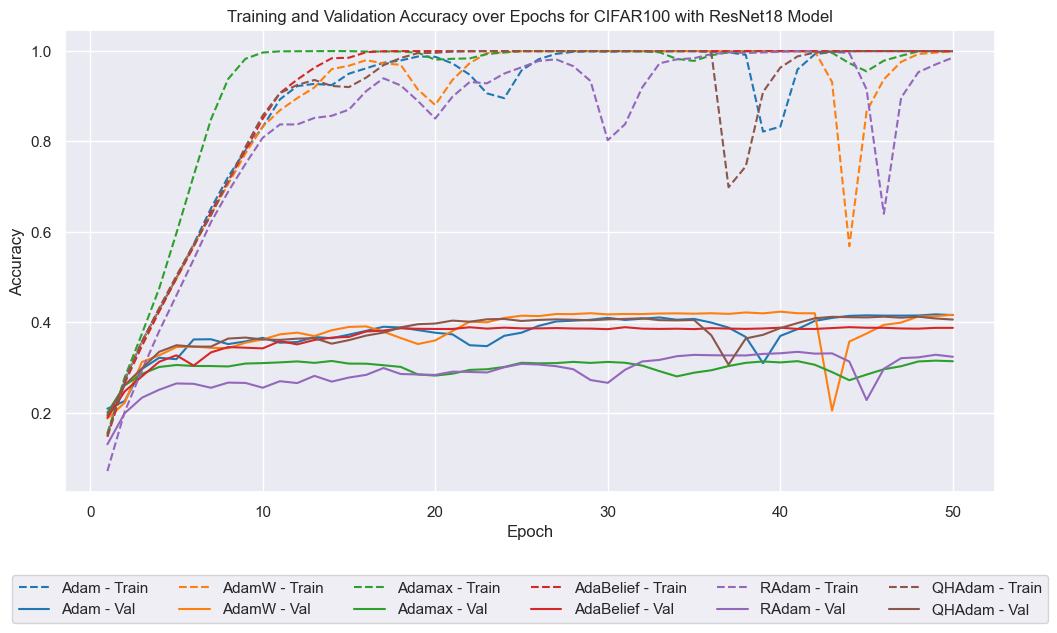

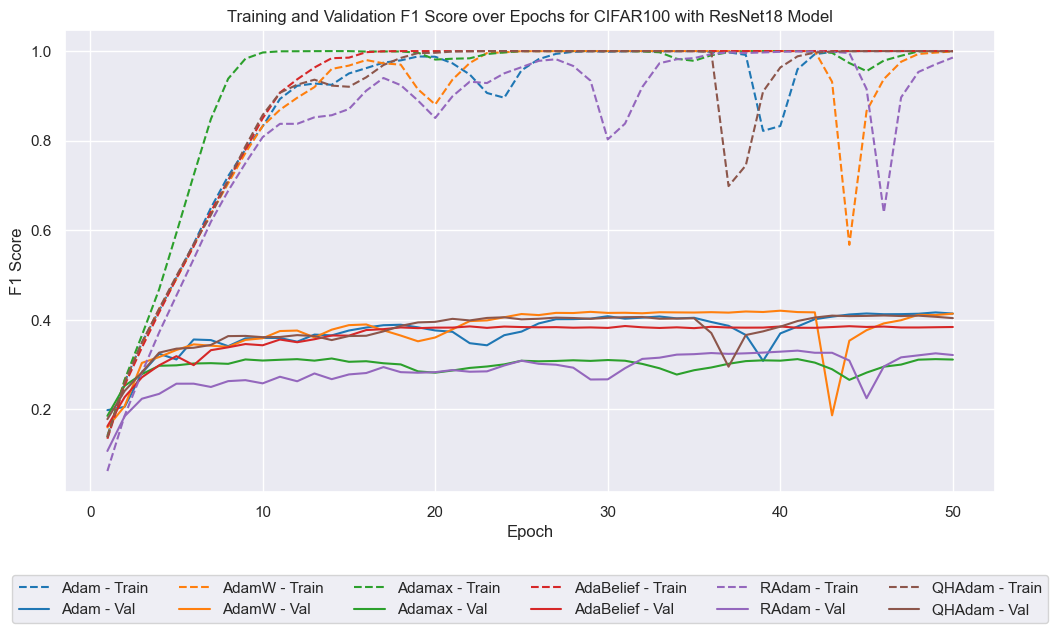

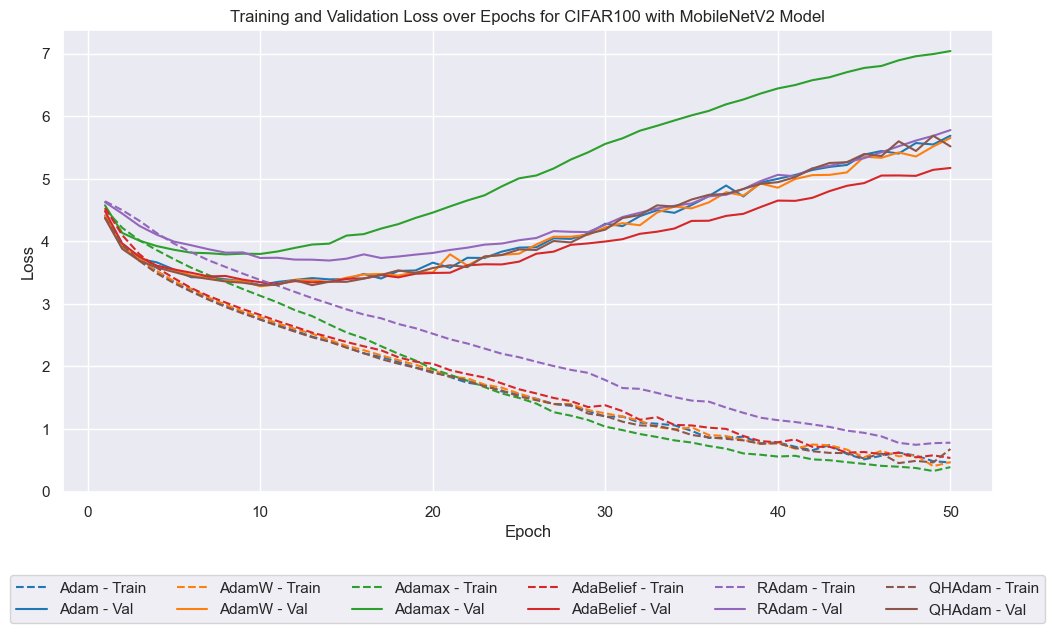

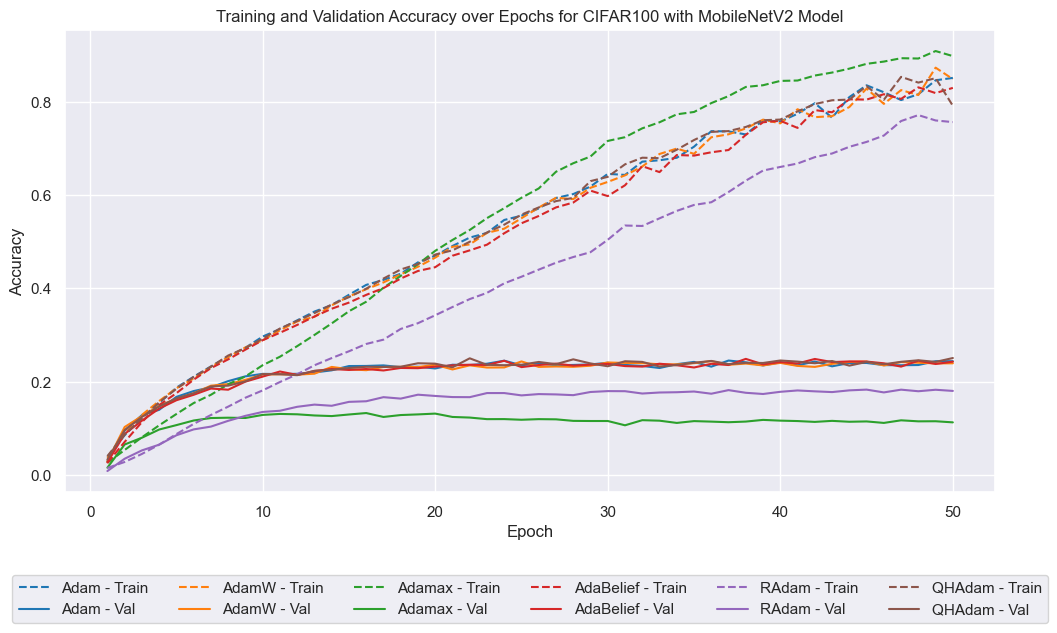

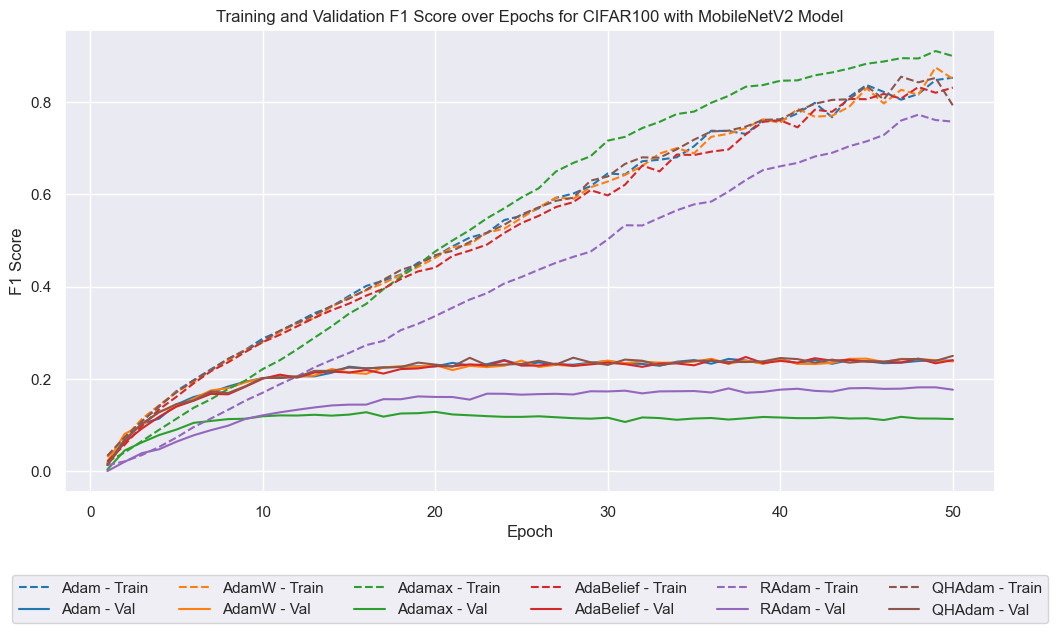

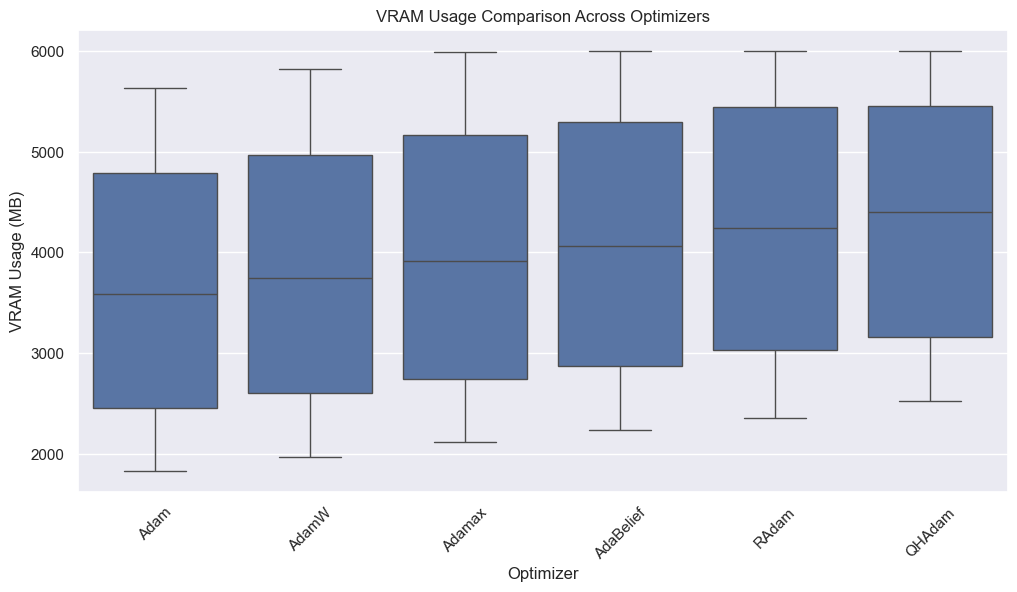

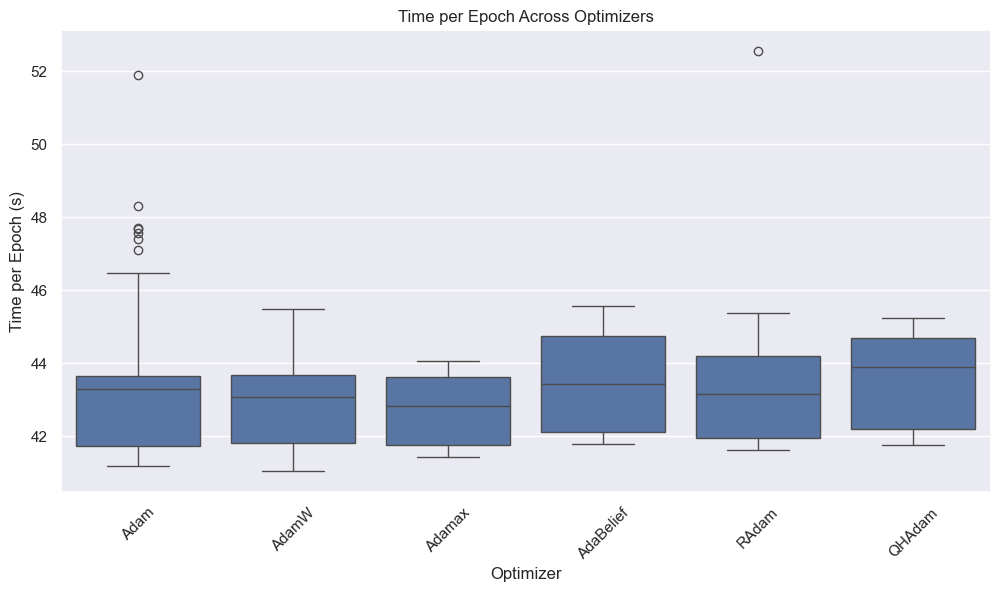

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

sns.set(style="darkgrid")

optimizers = df["Optimizer"].unique()
colors = itertools.cycle(sns.color_palette("tab10", len(optimizers)))

datasets = ['CIFAR10', 'CIFAR100']
models = ['ResNet18', 'MobileNetV2']

for dataset in datasets:
    for model in models:
        df_subset = df[(df["Dataset"] == dataset) & (df["Model"] == model)]

        if df_subset.empty:
            print(f"No data available for {model} on {dataset}. Skipping...")
            continue

        # --- Chart 1: Loss ---
        plt.figure(figsize=(12, 6))
        colors = itertools.cycle(sns.color_palette("tab10", len(optimizers)))
        for opt, color in zip(optimizers, colors):
            subset = df_subset[df_subset["Optimizer"] == opt]
            plt.plot(subset["Epoch"], subset["Train_Loss"], label=f"{opt} - Train", linestyle="dashed", color=color)
            plt.plot(subset["Epoch"], subset["Val_Loss"], label=f"{opt} - Val", color=color)

        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"Training and Validation Loss over Epochs for {dataset} with {model} Model")
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)
        plt.show()

        # --- Chart 2: Accuracy ---
        plt.figure(figsize=(12, 6))
        colors = itertools.cycle(sns.color_palette("tab10", len(optimizers)))
        for opt, color in zip(optimizers, colors):
            subset = df_subset[df_subset["Optimizer"] == opt]
            plt.plot(subset["Epoch"], subset["Train_Acc"], label=f"{opt} - Train", linestyle="dashed", color=color)
            plt.plot(subset["Epoch"], subset["Val_Acc"], label=f"{opt} - Val", color=color)

        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"Training and Validation Accuracy over Epochs for {dataset} with {model} Model")
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)
        plt.show()

        # --- Chart 3: F1 Score ---
        plt.figure(figsize=(12, 6))
        colors = itertools.cycle(sns.color_palette("tab10", len(optimizers)))
        for opt, color in zip(optimizers, colors):
            subset = df_subset[df_subset["Optimizer"] == opt]
            plt.plot(subset["Epoch"], subset["Train_F1"], label=f"{opt} - Train", linestyle="dashed", color=color)
            plt.plot(subset["Epoch"], subset["Val_F1"], label=f"{opt} - Val", color=color)

        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.title(f"Training and Validation F1 Score over Epochs for {dataset} with {model} Model")
        plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=6)
        plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Optimizer", y="VRAM(MB)", data=df)
plt.xlabel("Optimizer")
plt.ylabel("VRAM Usage (MB)")
plt.title("VRAM Usage Comparison Across Optimizers")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Optimizer", y="Time(s)", data=df)
plt.xlabel("Optimizer")
plt.ylabel("Time per Epoch (s)")
plt.title("Time per Epoch Across Optimizers")
plt.xticks(rotation=45)
plt.show()


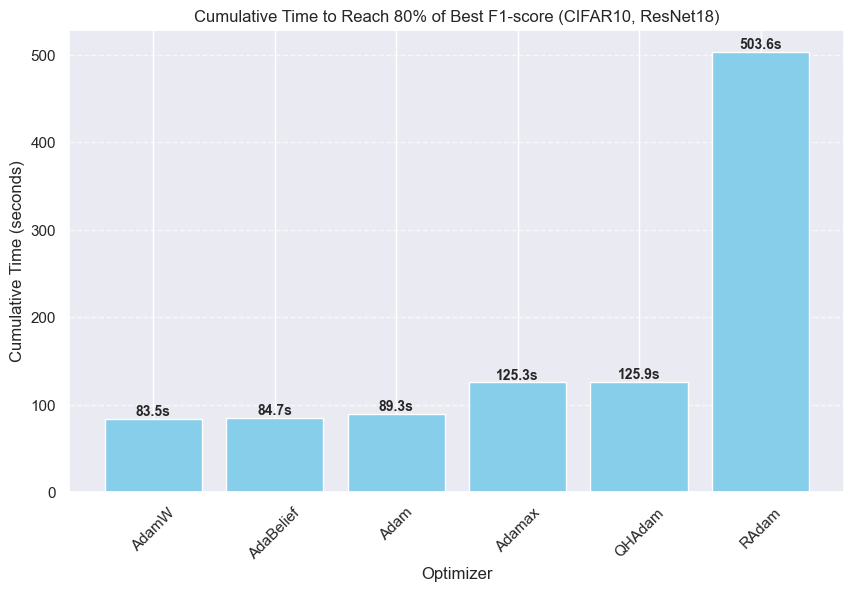

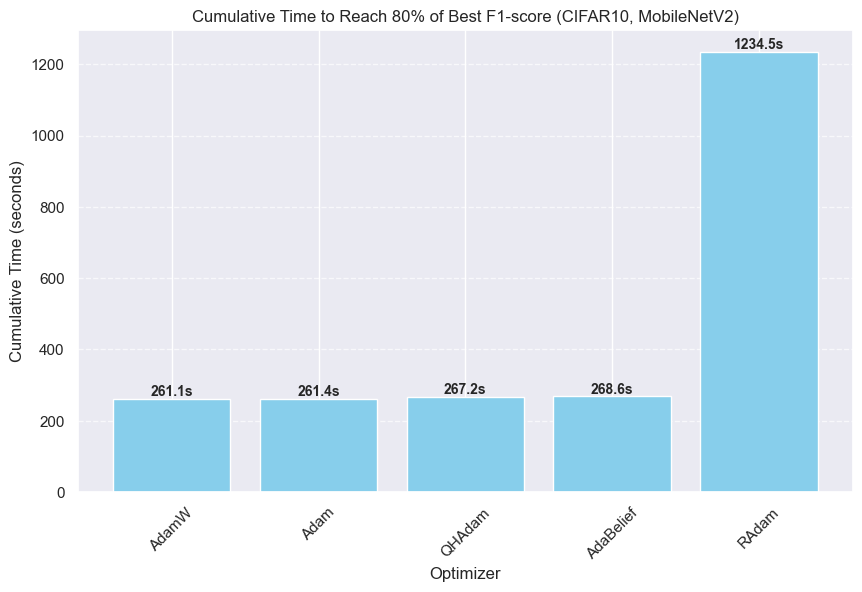

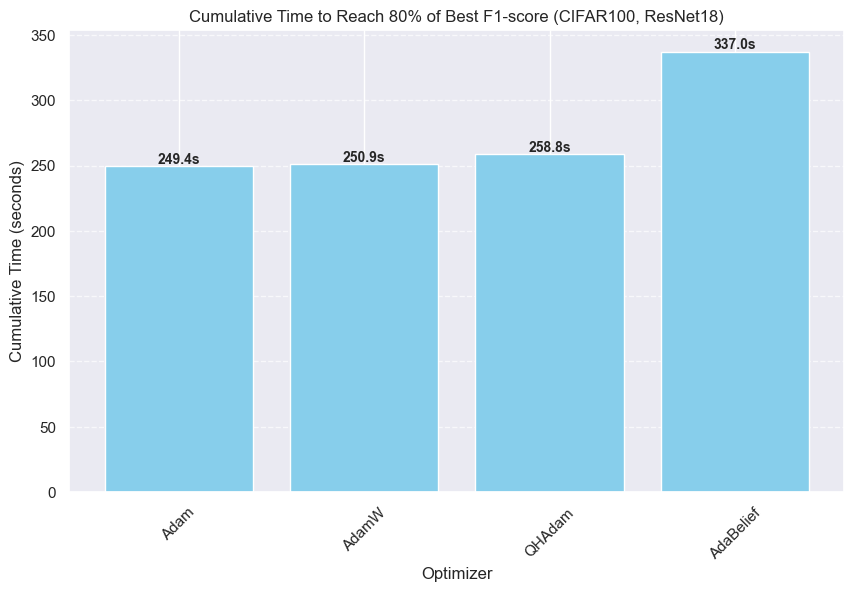

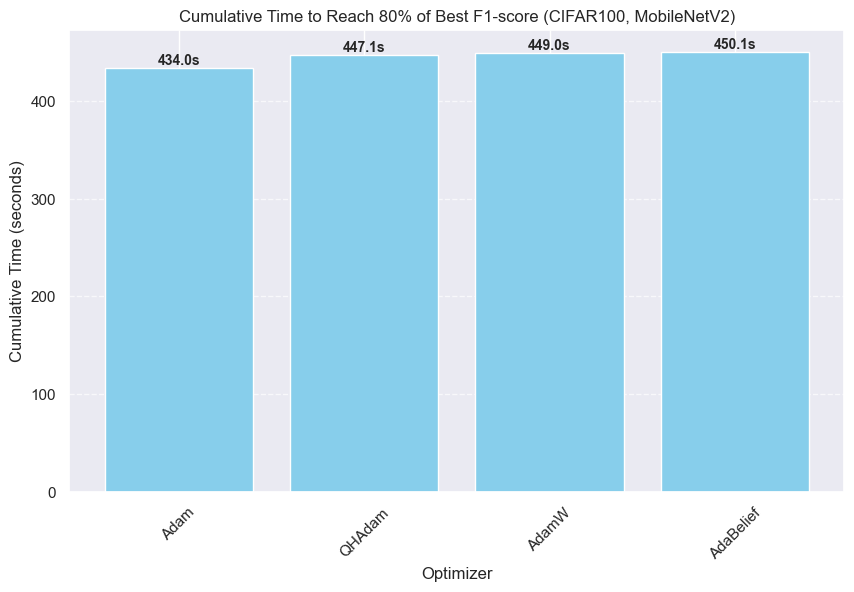

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")

# Define datasets and models
datasets = ['CIFAR10', 'CIFAR100']
models = ['ResNet18', 'MobileNetV2']

# Loop through each dataset and model combination
for dataset in datasets:
    for model in models:
        # Filter the DataFrame for the current dataset and model
        df_subset = df[(df["Dataset"] == dataset) & (df["Model"] == model)]

        # Check if the subset is empty
        if df_subset.empty:
            print(f"No data available for {model} on {dataset}. Skipping...")
            continue

        # Find the best overall F1-score
        best_overall_f1 = df_subset["Val_F1"].max()
        threshold_f1 = 0.8 * best_overall_f1

        # Find cumulative time taken by each optimizer to reach 80% of best F1-score
        optimizers = df_subset["Optimizer"].unique()
        time_to_threshold = {}

        for opt in optimizers:
            opt_df = df_subset[df_subset["Optimizer"] == opt].sort_values(by="Epoch")
            opt_df["Cumulative_Time"] = opt_df["Time(s)"].cumsum()  # Accumulate time over epochs

            reached = opt_df[opt_df["Val_F1"] >= threshold_f1]

            if not reached.empty:
                time_to_threshold[opt] = reached.iloc[0]["Cumulative_Time"]  # First time reaching threshold

        # Convert to DataFrame for plotting
        time_df = pd.DataFrame(list(time_to_threshold.items()), columns=["Optimizer", "Cumulative Time to 80% Best F1"])
        if time_df.empty:
            print(f"No optimizer reached 80% of best F1-score for {model} on {dataset}. Skipping plot...")
            continue
        time_df = time_df.sort_values(by="Cumulative Time to 80% Best F1")

        # Plot the results
        plt.figure(figsize=(10, 6))
        bars = plt.bar(time_df["Optimizer"], time_df["Cumulative Time to 80% Best F1"], color="skyblue")
        plt.ylabel("Cumulative Time (seconds)")
        plt.xlabel("Optimizer")
        plt.title(f"Cumulative Time to Reach 80% of Best F1-score ({dataset}, {model})")
        plt.xticks(rotation=45)
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        # Add text labels on top of the bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}s", ha='center', va='bottom', fontsize=10, fontweight="bold")

        plt.show()